In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)



In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
df = pd.read_csv('/home/ila/Desktop/Train/input.csv')
print(df.document_page_type.unique())
df.head()

['Referrals' 'MedicalRecordRequest_ROI' 'Unknown' 'Claims'
 'PatientAdmissions' 'PriorAuthorization' 'DischargeSummary']


,Unnamed: 0,id,file_path,document_page_type,text,file_name
0,0,1.0,/home/ila/Documents/Documents_Backup/dc_classi...,Referrals,ee Good Hospice Care\n\n \n\n \n\n \n\na\nSama...,1402336 - REFERRALADMISSION - REFERRAL-page0.txt
1,1,2.0,/home/ila/Documents/Documents_Backup/dc_classi...,Referrals,SN Stanford\nWY ch\n\nTO:\n\nFROM:\n\nRE:\n\n ...,ct18662345550-20190112030954773-205-2-page1.txt
2,2,3.0,/home/ila/Documents/Documents_Backup/dc_classi...,Referrals,TRICARE Patient Referral/Authorization Form In...,TRICARE_Patient_Referral_Auth_Form-page1.txt
3,3,4.0,/home/ila/Documents/Documents_Backup/dc_classi...,Referrals,"FAVOR LIVSH\n@ as |\n3, LEMDEUD\nLELS-HBl (P28...",ct18662345550-20190123093056590-296-18-page1.txt
4,4,5.0,/home/ila/Documents/Documents_Backup/dc_classi...,Referrals,Chiltven’s Fax Cover Sheet\n\nHEALTHCARE\n\n \...,ct18662345550-20190123093056590-296-18-page0.txt


In [4]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['ee Good Hospice Care a Samaritan Referral Hospital Physician / Name Dr. Jaci '
 'Gehman NPI 1935343365 Address 2275 South 132™ St, Suite 112 City Omaha State '
 'NE —s—s- Zip Code _68144-6023 Nurse / Contact Person Erin Thacker Phone (402 '
 '} 637-8000 PATIENT INFORMATION Patient Name Andrew Lincoln Address 801 N 3rd '
 'Ave City Omaha State NE Zip Code 68112 Home Phone (402 } 981 - 8612 Alt. '
 'Phone (402 } 598 - 8521 Social Security# _503 - 44 - 7467. DateofBirth 11/29 '
 '/ 38 Male _X_ Female _ DIAGNOSIS- Prognosis of 6 months or less OOcoPpD O '
 'Cancer OOCHF D Alzheimer’s M1 End-Stage Renal Failure OALs O Parkinson’s '
 '(end-stage) 1 Severe Debility O Other Please Fax the Following: Recent '
 'History and Physical Recent Labs & Diagnostic Studies List of current '
 'medications PATIENT INSURANCE INFORMATION Primary Insurance _United '
 'Healthcare Secondary Policy # _0568430R1000 Policy # Group # _85366 Group # '
 'Name of Insured _Andrew Lincoln Name of Insured xX Physician

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['ee', 'good', 'hospice', 'care', 'samaritan', 'referral', 'hospital', 'physician', 'name', 'dr', 'jaci', 'gehman', 'npi', 'address', 'south', 'st', 'suite', 'city', 'omaha', 'state', 'ne', 'zip', 'code', 'nurse', 'contact', 'person', 'erin', 'thacker', 'phone', 'patient', 'information', 'patient', 'name', 'andrew', 'lincoln', 'address', 'rd', 'ave', 'city', 'omaha', 'state', 'ne', 'zip', 'code', 'home', 'phone', 'alt', 'phone', 'social', 'security', 'dateofbirth', 'male', 'female', 'diagnosis', 'prognosis', 'of', 'months', 'or', 'less', 'oocoppd', 'cancer', 'oochf', 'alzheimer', 'end', 'stage', 'renal', 'failure', 'oals', 'parkinson', 'end', 'stage', 'severe', 'debility', 'other', 'please', 'fax', 'the', 'following', 'recent', 'history', 'and', 'physical', 'recent', 'labs', 'diagnostic', 'studies', 'list', 'of', 'current', 'medications', 'patient', 'insurance', 'information', 'primary', 'insurance', 'healthcare', 'secondary', 'policy', 'policy', 'group', 'group', 'name', 'of', 'insur

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod)
print(trigram_mod[bigram_mod[data_words[0]]])

['ee', 'good', 'hospice', 'care', 'samaritan', 'referral', 'hospital', 'physician', 'name', 'dr', 'jaci', 'gehman', 'npi', 'address', 'south', 'st', 'suite', 'city_omaha', 'state', 'ne', 'zip_code', 'nurse', 'contact', 'person', 'erin', 'thacker', 'phone', 'patient', 'information', 'patient', 'name', 'andrew', 'lincoln', 'address', 'rd', 'ave', 'city_omaha', 'state', 'ne', 'zip_code', 'home', 'phone', 'alt', 'phone', 'social_security', 'dateofbirth', 'male_female', 'diagnosis', 'prognosis', 'of', 'months', 'or', 'less', 'oocoppd', 'cancer', 'oochf', 'alzheimer', 'end_stage_renal', 'failure', 'oals', 'parkinson', 'end_stage', 'severe', 'debility', 'other', 'please', 'fax', 'the', 'following', 'recent', 'history', 'and', 'physical', 'recent', 'labs', 'diagnostic', 'studies', 'list', 'of', 'current_medications', 'patient', 'insurance', 'information', 'primary', 'insurance', 'healthcare', 'secondary', 'policy', 'policy', 'group', 'group', 'name', 'of', 'insured', 'lincoln', 'name', 'of', '

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# import sys
# !{sys.executable} -m pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
import spacy as spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'hospice', 'care', 'samaritan', 'referral', 'hospital', 'physician', 'name', 'dr', 'jaci', 'gehman', 'npi', 'address', 'south', 'st', 'suite', 'city', 'omaha', 'state', 'zip_code', 'nurse', 'contact', 'person', 'erin', 'thacker', 'phone', 'patient', 'information', 'patient', 'name', 'andrew', 'lincoln', 'address', 'rd', 'ave', 'city', 'omaha', 'state', 'zip_code', 'home', 'phone', 'alt', 'phone', 'social_security', 'dateofbirth', 'male_female', 'diagnosis', 'prognosis', 'month', 'less', 'oocoppd', 'cancer', 'oochf', 'alzheimer', 'end_stage', 'renal', 'failure', 'oal', 'parkinson', 'end_stage', 'severe', 'debility', 'fax', 'follow', 'recent', 'history', 'physical', 'recent', 'lab', 'diagnostic', 'study', 'list', 'patient', 'insurance', 'information', 'primary', 'insurance', 'healthcare', 'secondary', 'policy', 'policy', 'group', 'group', 'name', 'insure', 'lincoln', 'name', 'insure', 'physician', 'signature', 'start', 'date']]


In [11]:
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2), (30, 2), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 4), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 3), (47, 1), (48, 3), (49, 1), (50, 2), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 2)]]


In [12]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"current_medication" + 0.001*"overweight" + 0.000*"counsel" + '
  '0.000*"scrotum" + 0.000*"prostate" + 0.000*"breast" + 0.000*"ring" + '
  '0.000*"penis" + 0.000*"vulva" + 0.000*"cardio_pulmonary"'),
 (1,
  '0.056*"information" + 0.033*"health" + 0.029*"authorization" + '
  '0.027*"record" + 0.017*"release" + 0.016*"date" + 0.016*"request" + '
  '0.016*"medical" + 0.015*"patient" + 0.012*"sign"'),
 (2,
  '0.031*"blood_pressure" + 0.028*"pulse" + 0.025*"tobacco" + 0.023*"hand" + '
  '0.021*"bleed" + 0.013*"family" + 0.012*"soft" + 0.011*"negative" + '
  '0.009*"ion" + 0.008*"factor"'),
 (3,
  '0.000*"continuous" + 0.000*"conflict" + 0.000*"defibrillator" + '
  '0.000*"decisionmmaker" + 0.000*"decisianmaker" + 0.000*"cornfort" + '
  '0.000*"depend" + 0.000*"consistency" + 0.000*"caillfernia" + '
  '0.000*"capolst"'),
 (4,
  '0.025*"history" + 0.023*"med" + 0.021*"kidney" + 0.017*"regular" + '
  '0.016*"brain" + 0.016*"seizure" + 0.015*"attachment" + 0.015*"server" + '
  '0

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.29227133893423

Coherence Score:  0.4563331898612426


In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.404649  0.081525       1        1  38.212224
1      0.309046  0.156242       2        1  20.980212
5      0.282619 -0.258433       3        1  13.220563
12     0.068978 -0.152144       4        1   8.301814
13     0.153922  0.142696       5        1   5.202411
19     0.040111 -0.117422       6        1   4.359304
8     -0.007229 -0.008035       7        1   3.599372
15    -0.088320  0.010393       8        1   1.492278
2     -0.098474  0.010938       9        1   1.328447
4     -0.096462  0.002756      10        1   1.204032
9     -0.104073  0.014731      11        1   0.692171
17    -0.101444  0.017195      12        1   0.543019
11    -0.100436  0.014534      13        1   0.414979
14    -0.098484  0.013049      14        1   0.178289
6     -0.095609  0.012642      15        1   0.112294
18    -0.094617  0.012225      16        1   0.072136
0     -0.093807  0.011882      17        1   0.034149
16    -0.093510  0.011762      18        1   0.025755
3     -0.093429  0.011731      19        1   0.013409
7     -0.093429  0.011731      20        1   0.013140, topic_info=             Term         Freq        Total Category  logprob  loglift
18            fax   799.000000   799.000000  Default  30.0000  30.0000
28    information  1309.000000  1309.000000  Default  29.0000  29.0000
899         order   445.000000   445.000000  Default  28.0000  28.0000
9            date  1907.000000  1907.000000  Default  27.0000  27.0000
152        number   498.000000   498.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
5312          lof     0.000615     0.645353  Topic20  -9.6793   1.9819
5311        lagal     0.000615     0.645353  Topic20  -9.6793   1.9819
5310     innitial     0.000615     0.645352  Topic20  -9.6793   1.9819
5309       inital     0.000615     0.645352  Topic20  -9.6793   1.9819
5308   infrmalion     0.000615     0.645352  Topic20  -9.6793   1.9819

[1039 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2123      1  0.101712       aa
2123      4  0.889982       aa
2921     15  0.612908      aaa
2782      7  0.990351  abdoman
1172      2  0.281900  account
...     ...       ...      ...
1030      2  0.195002     year
1030      6  0.312003     year
1030      7  0.247002     year
1550     11  0.577957      yin
1551      8  0.948989      yrs

[848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 2, 6, 13, 14, 20, 9, 16, 3, 5, 10, 18, 12, 15, 7, 19, 1, 17, 4, 8])

In [23]:
import os
os.environ.update({'MALLET_HOME':r'/home/ila/Documents/repos/python-works/artificialintelligence/topic_modelling/mallet-2.0.8/bin/mallet'})
mallet_path = '/home/ila/Documents/repos/python-works/artificialintelligence/topic_modelling/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=16, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('order', 0.062245359891353554),
   ('phone', 0.0441376188320507),
   ('active', 0.033499320959710276),
   ('date', 0.03282028066998642),
   ('day', 0.024671797193300135),
   ('time', 0.019692168401991852),
   ('give', 0.01923947487550928),
   ('summary', 0.01923947487550928),
   ('nurse', 0.016523313716613853),
   ('confirm', 0.01403349932095971)]),
 (5,
  [('information', 0.07819763976636071),
   ('record', 0.05781380379067827),
   ('authorization', 0.047085469066634876),
   ('health', 0.045893431875074504),
   ('release', 0.03361544880200262),
   ('medical', 0.02252950292049112),
   ('request', 0.02038383597568244),
   ('disclosure', 0.01990702109905829),
   ('sign', 0.01978781737990225),
   ('understand', 0.018357372750029802)]),
 (7,
  [('date', 0.0366617538688283),
   ('dental', 0.029108327192336036),
   ('number', 0.02763448784082535),
   ('treatment', 0.025976418570375828),
   ('address', 0.02431834929992631),
   ('plan', 0.018607221812822403),
   ('information', 0.015

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


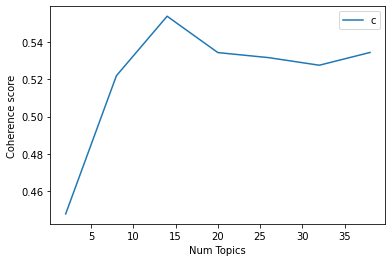

In [26]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has Coherence Value of", round(cv, 4))


Num Topics =  2  has Coherence Value of 0.4476
Num Topics =  8  has Coherence Value of 0.522
Num Topics =  14  has Coherence Value of 0.554
Num Topics =  20  has Coherence Value of 0.5344
Num Topics =  26  has Coherence Value of 0.5317
Num Topics =  32  has Coherence Value of 0.5276
Num Topics =  38  has Coherence Value of 0.5345


In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.087*"order" + 0.077*"date" + 0.029*"nurse" + 0.023*"summary" + '
  '0.022*"resident" + 0.022*"confirm" + 0.016*"verbal" + 0.015*"location" + '
  '0.012*"delano" + 0.011*"communication_method"'),
 (1,
  '0.021*"report" + 0.019*"patient" + 0.016*"client" + 0.015*"age" + '
  '0.014*"associate" + 0.012*"test" + 0.012*"health" + 0.012*"range" + '
  '0.011*"page" + 0.008*"comment"'),
 (2,
  '0.038*"date" + 0.029*"center" + 0.022*"time" + 0.021*"medical" + '
  '0.020*"discharge" + 0.018*"hospital" + 0.016*"avenue" + 0.016*"clinic" + '
  '0.015*"pst" + 0.013*"result"'),
 (3,
  '0.047*"primary" + 0.027*"date" + 0.019*"admission" + 0.018*"effective" + '
  '0.017*"insurance" + 0.016*"contact" + 0.015*"type" + 0.015*"previous" + '
  '0.014*"medicaid" + 0.013*"hospital"'),
 (4,
  '0.019*"family" + 0.014*"physical" + 0.013*"care" + 0.013*"history" + '
  '0.013*"weight" + 0.012*"visit" + 0.012*"assessment" + 0.011*"eye" + '
  '0.011*"child" + 0.011*"test"'),
 (5,
  '0.098*"patient" + 0.063*

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3901,"address, phone, date, information, birth, prov...",ee Good Hospice Care a Samaritan Referral Hosp...
1,1,16.0,0.2968,"patient, pm, physician, refer, md, page, exam,...",SN Stanford WY ch TO: FROM: RE: Packard evs Ne...
2,2,10.0,0.5874,"service, patient, form, care, number, provider...",TRICARE Patient Referral/Authorization Form In...
3,3,13.0,0.3353,"eee, ee, ae, oe, os, aa, ol, ot, ss, pee","FAVOR LIVSH @ as | 3, LEMDEUD LELS-HBl (P28) H..."
4,4,11.0,0.4531,"fax, number, page, information, phone, message...",Chiltven’s Fax Cover Sheet HEALTHCARE 90 Valle...
5,5,13.0,0.2986,"eee, ee, ae, oe, os, aa, ol, ot, ss, pee",HESOA LIV SH SUOIDHUD Aaye As OLSO-CEL (PEL) H...
6,6,10.0,0.2878,"service, patient, form, care, number, provider...",XK jKTRIWES TRICARE IRIWEST West TRICARE PATIE...
7,7,10.0,0.2648,"service, patient, form, care, number, provider...",Texas Referral/Authorization Form Please fill ...
8,8,9.0,0.4301,"address, phone, date, information, birth, prov...","REFERRAL Dolan, Henkin, MD Quynn Sutton 12/05/..."
9,9,5.0,0.3100,"patient, physician, referral, medication, note...",Peed PROVIDER REFERRAL REQUEST FORM Specialty:...


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()
import os
os.environ.update({'MALLET_HOME':r'mallet-2.0.8/bin/mallet'})
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('date', 0.046147507210548),
   ('time', 0.03914297486608982),
   ('medical', 0.023485784919653894),
   ('facility', 0.023073753605274),
   ('day', 0.015657189946435928),
   ('patient', 0.015245158632056036),
   ('appointment', 0.014833127317676144),
   ('type', 0.014009064688916358),
   ('ray', 0.013597033374536464),
   ('transport', 0.013185002060156572)]),
 (19,
  [('fax', 0.06632213608957795),
   ('information', 0.0614412862474878),
   ('receive', 0.024691358024691357),
   ('communication', 0.022107378696525983),
   ('document', 0.01923629055412001),
   ('confidential', 0.018662072925638817),
   ('law', 0.014642549526270457),
   ('disclosure', 0.01435544071202986),
   ('call', 0.014068331897789263),
   ('intended_recipient', 0.013781223083548665)]),
 (2,
  [('medical', 0.04905660377358491),
   ('ave', 0.03471698113207547),
   ('physician', 0.026037735849056602),
   ('avenue', 0.019245283018867923),
   ('center', 0.019245283018867923),
   ('patient', 0.015471698113207547),
 

In [31]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"address, phone, date, information, birth, prov...",54.0,0.0860
1.0,16.0,"patient, pm, physician, refer, md, page, exam,...",18.0,0.0287
2.0,10.0,"service, patient, form, care, number, provider...",18.0,0.0287
3.0,13.0,"eee, ee, ae, oe, os, aa, ol, ot, ss, pee",45.0,0.0717
4.0,11.0,"fax, number, page, information, phone, message...",26.0,0.0414
...,...,...,...,...
623.0,5.0,"patient, physician, referral, medication, note...",NaN,NaN
624.0,14.0,"history, pain, leave, normal, symptom, recent,...",NaN,NaN
625.0,11.0,"fax, number, page, information, phone, message...",NaN,NaN
626.0,2.0,"date, center, time, medical, discharge, hospit...",NaN,NaN
